In [1]:
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170, r41, r23, r161, r152a, r152, r134, r143, r116
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
from fffit.fffit.utils import values_real_to_scaled, values_scaled_to_real, variances_scaled_to_real, generate_lhs
from fffit.fffit.plot import plot_obj_contour
import os

2025-06-24 11:17:21.737615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750778241.758348  344098 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750778241.764633  344098 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750778241.782466  344098 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750778241.782489  344098 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750778241.782491  344098 computation_placer.cc:177] computation placer alr

In [2]:
r14_class = r14.R14Constants()
r32_class = r32.R32Constants()
r50_class = r50.R50Constants()
r125_class = r125.R125Constants()
r134a_class = r134a.R134aConstants()
r143a_class = r143a.R143aConstants()
r170_class = r170.R170Constants()
r41_class = r41.R41Constants()

In [7]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import seaborn
from matplotlib import ticker

result_bounds = [0,35]
str_mol = "R14"
at_list = ["gaff", 1, 2]
molec_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class, "R41": r41_class}
data_class = molec_dict[str_mol]

# ID the top ten by lowest average MAPE
#Get params < 10
molec_data = []
for at_num in at_list:
    molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a", "R41"] #Training data to consider
    #Create visualization object
    
    #Get parameter sets
    if isinstance(at_num, int):  
        analyzer = opt_atom_types.Vis_Results(molec_names, at_num, 1, "ExpVal")
        #Load param_set
        param_matrix = analyzer.at_class.get_transformation_matrix(
                {str_mol: analyzer.molec_data_dict[str_mol]})
        #Set parameter set of interest (in this case get the best parameter set)
        all_molec_dir = analyzer.use_dir_name
        data_set = pd.read_csv(os.path.join(all_molec_dir, "unique_best_set.csv"), header =0, index_col = False)
        
        # param_best = analyzer.values_pref_to_real()
        bnds =  analyzer.at_class.at_bounds_nm_kjmol.T@param_matrix
        param_best = values_real_to_scaled(analyzer.values_pref_to_real(data_set.iloc[0].values@param_matrix).reshape(1,-1), bnds.T)
        #Get MAPD for R50 (rho_l and Hvap only)
        err_file = os.path.join("Results_MS", analyzer.at_class.scheme_name, "ExpVal", "param_set_1", "opt_ff_ms_err.csv")
        errs = pd.read_csv(err_file, header =0, index_col =False)
        #Add the columns for MAPD for rho_l and Hvap to param_best
        # Convert errs to a dictionary keyed by molecule
        mapd_liq = values_real_to_scaled(errs.loc[errs["molecule"] == str_mol, "mapd_liq_density"].values[0], result_bounds)
        mapd_hvap = values_real_to_scaled(errs.loc[errs["molecule"] == str_mol, "mapd_Hvap"].values[0], result_bounds)

        # Concatenate the MAPD values to `param_best`
        param_best_with_mapd = np.append(param_best, [mapd_liq, mapd_hvap])
        print(param_best_with_mapd)

    else:
        at_num = 1
        analyzer = opt_atom_types.Vis_Results(molec_names, at_num, 1, "ExpVal")
        param_matrix = analyzer.at_class.get_transformation_matrix(
                {str_mol: analyzer.molec_data_dict[str_mol]})
        molec_gaff = np.array(
            list(data_class.gaff_param_set.values())
        )

        bnds =  analyzer.at_class.at_bounds_nm_kjmol.T@param_matrix
        param_best = values_real_to_scaled(analyzer.values_pref_to_real(molec_gaff).reshape(1,-1), bnds.T)

        # param_best = analyzer.values_pref_to_real(molec_gaff)
        err_file = os.path.join("Results_MS", "", "", "", "gaff_ff_ms_err.csv") 
        errs = pd.read_csv(err_file, header =0, index_col =False)
        
        #Add the columns for MAPD for rho_l and Hvap to param_best
        # Convert errs to a dictionary keyed by molecule
        # mapd_liq = errs.loc[errs["molecule"] == str_mol, "mapd_liq_density"].values[0]
        # mapd_hvap = errs.loc[errs["molecule"] == str_mol, "mapd_Hvap"].values[0]
        mapd_liq = values_real_to_scaled(errs.loc[errs["molecule"] == str_mol, "mapd_liq_density"].values[0], result_bounds)
        mapd_hvap = values_real_to_scaled(errs.loc[errs["molecule"] == str_mol, "mapd_Hvap"].values[0], result_bounds)
        param_best_with_mapd = np.append(param_best, [mapd_liq, mapd_hvap])
    molec_data.append(param_best_with_mapd)
# param_names = []
# for name in data_class.param_names:
#     latex_name = lambda s: fr"$\{s.split('_',1)[0]}_{{{s.split('_',1)[1]}}}$" if '_' in s else fr"${s}$"
#     param_names.append(latex_name(name))
param_names = list(data_class.param_names)
col_names = param_names + ["MAPE\n" + r"$\rho_{l}$", "MAPE\n" + r"$H_{vap}$"]
print("Column names: ", col_names)
df = pd.DataFrame(data=molec_data, columns = col_names )
# result_bounds = np.array([[0, 30], [0, 30]])
# df = pd.read_csv("Build_GPs/analysis/" + str + "/ld_iters/mse-less10-full.csv", header = 0, index_col=0)
df






[0.68056808 0.46907744 0.67398568 0.32111556 0.07159963 0.12047494]
[0.66929383 0.470316   0.67943018 0.32861872 0.06483026 0.10778753]
Column names:  ['sigma_C1', 'sigma_F1', 'epsilon_C1', 'epsilon_F1', 'MAPE\n$\\rho_{l}$', 'MAPE\n$H_{vap}$']


,sigma_C1,sigma_F1,epsilon_C1,epsilon_F1,MAPE\n$\rho_{l}$,MAPE\n$H_{vap}$
0,0.700000,0.559000,0.693108,0.448457,0.128519,0.922271
1,0.680568,0.469077,0.673986,0.321116,0.071600,0.120475
2,0.669294,0.470316,0.679430,0.328619,0.064830,0.107788


[[0.7        0.559      0.69310769 0.44845714 0.12851868 0.92227148]
 [0.68056808 0.46907744 0.67398568 0.32111556 0.07159963 0.12047494]
 [0.66929383 0.470316   0.67943018 0.32861872 0.06483026 0.10778753]]
[[ 2.          4.        ]
 [ 2.          4.        ]
 [10.00055586 75.00416898]
 [15.0008338  50.00277932]
 [ 0.         35.        ]
 [ 0.         35.        ]]
Column names:  ['$\\sigma_{C}$', '$\\sigma_{F}$', '$\\epsilon_{C}$', '$\\epsilon_{F}$', 'MAPD\n$\\rho_{l}$', 'MAPD\n$H_{vap}$']


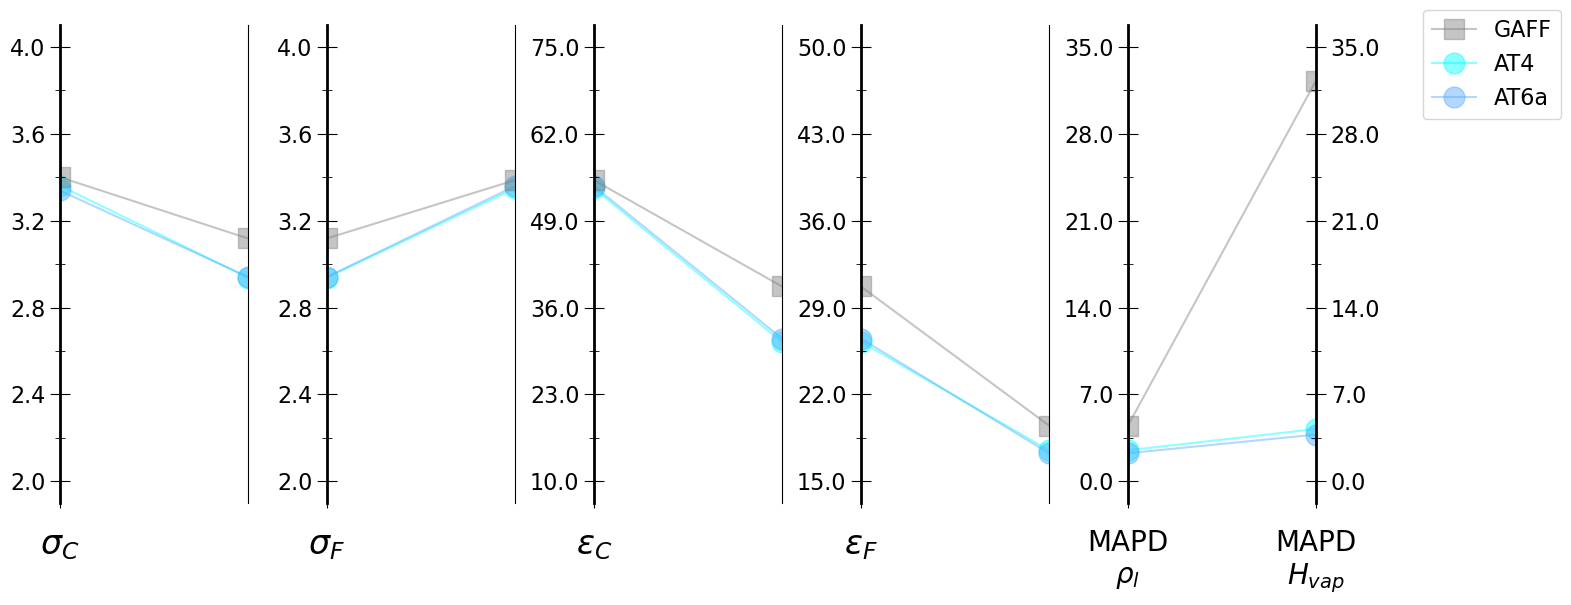

In [8]:
matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Arial")

NM_TO_ANGSTROM = 10
K_B = 0.008314 # J/MOL K
KJMOL_TO_K = 1.0 / K_B

def set_ticks_for_axis(ax, param_bounds, nticks):
    """Set the tick positions and labels on y axis for each plot

    Tick positions based on normalised data
    Tick labels are based on original data
    """
    min_val, max_val = param_bounds
    step = (max_val - min_val) / float(nticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(nticks)]
    ticks = np.linspace(0, 1.0, nticks)
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels, fontsize=16)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params("y", direction="inout", which="both", length=7)
    ax.tick_params("y", which="major", length=14)
    ax.tick_params("x", pad=15) 

seaborn.set_palette('bright', n_colors=len(df))
data = df.to_numpy()
print(data)
# data = df[list(data_class.param_names)].values
result_bounds = np.array([[0, 35], [0, 35]])
# results =  values_real_to_scaled(df[["mapd_liq_density", "mapd_Hvap"]].values, result_bounds)
param_bounds = bnds.T #data_class.param_bounds
# print(data_class.param_bounds)
indx_mid = int(len(data_class.param_names) / 2)
param_bounds[:indx_mid] = param_bounds[:indx_mid] * NM_TO_ANGSTROM
param_bounds[indx_mid:] = param_bounds[indx_mid:] * KJMOL_TO_K

# data = np.hstack((data, results))
bounds = np.vstack((param_bounds, result_bounds))
print(bounds)

col_names = []
for name in data_class.param_names:
    latex_name = lambda s: fr"$\{s.split('_',1)[0]}_{{{s.split('_',1)[1]}}}$" if '_' in s else fr"${s}$"
    col_names.append(latex_name(name))
col_names += ["MAPD\n" + r"$\rho_{l}$", "MAPD\n" + r"$H_{vap}$"]
col_names = [name.replace("1", "") for name in col_names]
print("Column names: ", col_names)
n_axis = len(col_names)
assert data.shape[1] == n_axis
x_vals = [i for i in range(n_axis)]

# Create (N-1) subplots along x axis
fig, axes = plt.subplots(1, n_axis-1, sharey=False, figsize=(14,6))

# Plot each row
labels = ["GAFF", "AT4", "AT6a"]
cmap = plt.get_cmap("cool")  # Get the rainbow colormap
df_colors = ['gray'] + [cmap(i) for i in np.linspace(0, 1, 4)]
markers = ["s", "o", "o"]
for i, ax in enumerate(axes):
    for j, line in enumerate(data):
        if j == 0:
            zorder = 1
        else:
            zorder = 0
        if i ==0:
            ax.plot(x_vals, line, alpha = 0.45, label = labels[j], color = df_colors[j], markersize = 15, marker = markers[j], zorder = zorder)
        else:
            ax.plot(x_vals, line, alpha = 0.45, color = df_colors[j], markersize = 15, marker = markers[j], zorder = zorder)
    ax.set_xlim([x_vals[i], x_vals[i+1]])

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(ax, bounds[dim], nticks=6)
    if dim < 10:
        ax.set_xticklabels([col_names[dim]], fontsize=24)
    else:
        ax.set_xticklabels([col_names[dim]], fontsize=20)
    ax.set_ylim(-0.05,1.05)
    # Add white background behind labels
    for label_y in ax.get_yticklabels():
        label_y.set_bbox(
            dict(
                facecolor='white',
                edgecolor='none',
                alpha=0.45,
                boxstyle=mpatch.BoxStyle("round4")
            )
        )
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)

ax = axes[-1]
ax.xaxis.set_major_locator(ticker.FixedLocator([n_axis-2, n_axis-1]))
ax.set_xticklabels([col_names[-2], col_names[-1]], fontsize=20)

ax = plt.twinx(axes[-1])
ax.set_ylim(-0.05, 1.05)
set_ticks_for_axis(ax, bounds[-1], nticks=6)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_linewidth(2.0)

# Remove space between subplots
plt.subplots_adjust(wspace=0, bottom=0.3)
handles, labels = axes[0].get_legend_handles_labels()
# Add legend to the figure (not to a single axis), position top right outside the plot area
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=16)
plt.tight_layout()
# fig.subplots_adjust(left=0, right=50, bottom=0, top=25)

# fig.savefig("Results_MS/R50-param-comp.png",dpi=360)


In [ ]:
#Load class properies for each molecule
r14_class = r14.R14Constants()
r32_class = r32.R32Constants()
r50_class = r50.R50Constants()
r125_class = r125.R125Constants()
r134a_class = r134a.R134aConstants()
r143a_class = r143a.R143aConstants()
r170_class = r170.R170Constants()
r41_class = r41.R41Constants()
molec_data_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class, "R41": r41_class}
df = pd.DataFrame(columns = ["Molecule", "Property", "Value", "Uncertainty", "Weight"])
for key in list(molec_data_dict.keys()):
    molec_object = molec_data_dict[key]
    for prop_key in list(molec_object.uncertainties.keys()):
        if "vap_density" in prop_key:
            exp_data = molec_object.expt_vap_density
            property_bounds = molec_object.vap_density_bounds
            property_name = "Vapor Density [kg/m^3]"
        elif "liq_density" in prop_key:
            exp_data = molec_object.expt_liq_density
            property_bounds = molec_object.liq_density_bounds
            property_name = "Liquid Density [kg/m^3]"
        elif "Pvap" in prop_key: 
            exp_data = molec_object.expt_Pvap
            property_bounds = molec_object.Pvap_bounds
            property_name = "Vapor pressure [bar]"
        elif "Hvap" in prop_key:
            exp_data = molec_object.expt_Hvap
            property_bounds = molec_object.Hvap_bounds
            property_name = "Enthalpy of Vaporization [kJ/kg]"

        values = np.array(list(exp_data.values()))
        y_unc = molec_object.uncertainties[prop_key]
        y_var_unc = (values*y_unc)** 2
        y_var_2pct = (values*0.02) ** 2
        y_var = np.maximum(y_var_unc, y_var_2pct)
        weight = 1 / y_var
        df_vals = [key, prop_key, values, y_unc, weight]
        iter_df = pd.DataFrame([df_vals], columns = df.columns)
        iter_df = iter_df.apply(lambda col: col.explode(), axis=0).reset_index(drop=True).copy(deep =True)
        df = pd.concat([df, iter_df], ignore_index=True)
print(df.head())
df.to_csv("molecule_exp_unc_data.csv", index = False, header = True)

In [ ]:
repeats = 1
seed = 1
at_number = 2
save_data = False
obj_choice = "ExpVal"
# obj_choice_p = "ExpValPrior"
mol_name_train = ["R41"]
analyzer = opt_atom_types.Analyze_opt_res(mol_name_train, at_number, seed, obj_choice)
param_matrix = analyzer.at_class.get_transformation_matrix(
                {mol_name_train[0]: analyzer.molec_data_dict[mol_name_train[0]]})
#Get full GAFF
gaff_params = np.array([0.34, 0.3118, 0.274, 0.45773, 0.255221, 0.06569256])
gaff_full = param_matrix@gaff_params.reshape(-1,1)
obj = analyzer.calc_obj(gaff_full)[0]
print(obj)

#Get full Lit
lit_params  = np.array(list(analyzer.molec_data_dict[mol_name_train[0]].lit_param_set.values()))
lit_params = analyzer.values_pref_to_real(lit_params)
lit_params_full = param_matrix@lit_params.reshape(-1,1)
obj = analyzer.calc_obj(lit_params_full)[0]
print(obj)

#Get Full Opt
x_label = "best_set"
all_molec_dir = analyzer.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = analyzer.at_class.at_names[0] + "_min"
last_param_name = analyzer.at_class.at_names[-1] + "_min"
all_sets = all_df.loc[:, first_param_name:last_param_name].values
best_ff = all_sets[0]
gen_ff_full = analyzer.values_pref_to_real(best_ff)
obj = analyzer.calc_obj(gen_ff_full)[0]
print(obj)

In [ ]:
import scipy 
import os
repeats = 1
seed = 1
#Get obj from a set of parameters
at_class = 2
obj_choice = "ExpVal"
# obj_choice_p = "ExpValPrior"
molec_names = ["R41"]
# at_optimizer =  opt_atom_types.Opt_ATs(molec_names, at_class, repeats, seed, obj_choice)
all_gp_dict = opt_atom_types.get_gp_data_from_pkl(molec_names)
visual = opt_atom_types.Vis_Results(molec_names, at_class, seed, obj_choice)
best_res = visual.get_best_results("R41")

param_vals = {"GAFF": gaff_full, "Lit": lit_params_full, "SingleOpt": gen_ff_full}
visual.compare_T_prop_best(param_vals, molec_names)

In [ ]:
#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpValPrior" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"] #Training data to consider

#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)
#Set parameter set of interest (in this case get the best parameter set)
x_label = "best_set"
all_molec_dir = visual.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
print(path_best_sets)
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = visual.at_class.at_names[0] + "_min"
last_param_name = visual.at_class.at_names[-1] + "_min"
all_sets = all_df.loc[:, first_param_name:last_param_name].values
unique_best_sets = visual.get_unique_sets(all_sets, 0.05, save_data, save_label=x_label)
print(unique_best_sets)

In [ ]:
#Load in molecgp_data R32 vap gp from pkl file
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"]
molecgp_data = opt_atom_types.get_gp_data_from_pkl(molec_names)
model = molecgp_data["R14"]['sim_Hvap']
hyperparameters = {
        'Mean Fxn A': model.mean_function.A.numpy(),
        'Mean Fxn B': model.mean_function.b.numpy(),
        'kernel_variance': model.kernel.variance.numpy(),
        'kernel_lengthscale': model.kernel.lengthscales.numpy(),
        'likelihood_variance': model.likelihood.variance.numpy()
    }
print(hyperparameters)

In [ ]:
#Imports
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
import os
import copy
import scipy 
import signac
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpVal" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a", "R41"] #Training data to consider

#Get best_run data saved in one csv from all jobs
project = signac.get_project("opt_at_params")
#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)

def get_pref_theta(molec_names, at_number_list, obj_choices_list, old_list, which_list,  param_set):
    mapds_dfs = []

    for at_number, obj_choice, old, which, param in zip(at_number_list,obj_choices_list, old_list, which_list, param_set):
        visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)
        all_molec_dir = visual.use_dir_name #- "-R41"
        if obj_choice == "ExpValPrior":
            all_molec_dir = str(all_molec_dir).replace("-R41", "")
        if old:
            all_molec_dir = str(all_molec_dir).replace("Results", "Results-OldGP")
        try:
            if os.path.exists(os.path.join(all_molec_dir, "unique_best_set.csv")):
                path_best_sets = os.path.join(all_molec_dir, "unique_best_set.csv")
                all_df = pd.read_csv(path_best_sets, header = 0)
                first_param_name = visual.at_class.at_names[0]
                last_param_name = visual.at_class.at_names[-1]
                best_set = all_df.loc[param, first_param_name:last_param_name].values
            
            else:
                path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
                all_df = pd.read_csv(path_best_sets, header = 0)
                first_param_name = visual.at_class.at_names[0] + "_min"
                last_param_name = visual.at_class.at_names[-1] + "_min"
                best_set = all_df.loc[param, first_param_name:last_param_name].values
            best_real = visual.values_pref_to_real(copy.copy(best_set))
        except:
            best_real = None
        
        # mapds = visual.calc_MAPD_mimic_ms(molec_names, best_set)
        dfs = visual.calc_MAPD_best(molec_names, best_real)
        mapds_dfs.append(dfs[which])

    return mapds_dfs

# at_schemes = [1, 2, 3,4,5,8,11,1]
at_schemes = [0, 1, 2, 6,8,1]
# old_list = [False, False, False, False, False, False, False, False]
old_list = [False, False, False, False, False, False]
# objs = ["ExpVal", "ExpVal", "ExpVal", "ExpVal", "ExpVal", "ExpVal", "ExpValPrior", "ExpVal"]
objs = ["ExpVal", "ExpVal", "ExpVal", "ExpVal", "ExpVal", "ExpVal"]
# which = ["Opt_All", "Opt_All", "Opt_All", "Opt_All", "Opt_All", "Opt_All", "Opt_All", "Literature"]
which = ["Opt_All", "Opt_All", "Opt_All", "Opt_All", "Opt_All", "GAFF"]
param_set = [0,0,0,0,0,0]
mapd_dfs = get_pref_theta(molec_names, at_schemes, objs, old_list, which, param_set)
average_mapds = []
# Iterate over each DataFrame in the list
for df in mapd_dfs:
    # Select the columns that contain 'mapd' in their name
    mapd_columns = df.filter(like='mapd')
    # Calculate the mean MAPD across all rows and columns in the DataFrame
    overall_average_mapd = mapd_columns.values.mean()
    # Append the overall average MAPD to the result list
    average_mapds.append(overall_average_mapd)
# Display results
for i, avg_mapd in enumerate(average_mapds):
     print(f"Average MAPD for DataFrame {i + 1}: {avg_mapd}")
# df_labels = ["Literature", "5% eps_C1 Wt", "20% eps_C1 Wt"]
# df_colors = ["blue", "orange", "green"]
df_labels = ["AT-3", "AT-4", "AT-6a", "AT-6b", "AT-8", "GAFF"]#, "AT-06", "AT-08", "AT-11", "Lit."]
cmap = plt.get_cmap("rainbow")  # Get the rainbow colormap
df_colors = [cmap(i) for i in np.linspace(0, 1, len(df_labels))]
title = "Atom Type GP Comparison"
# visual.plot_avg_MAPD(mapd_dfs, df_labels, df_colors, title)
visual.plot_MAPD(mapd_dfs, df_labels, df_colors, title)

In [ ]:

#Imports
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
import os
import copy
import scipy 
import signac
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpValPrior" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"] #Training data to consider

#Get best_run data saved in one csv from all jobs
project = signac.get_project("opt_at_params")
#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)

#Set parameter set of interest (in this case get the best parameter set)
all_molec_dir = visual.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = visual.at_class.at_names[0] + "_min"
last_param_name = visual.at_class.at_names[-1] + "_min"
best_set = all_df.loc[0, first_param_name:last_param_name].values
# path_best_sets = os.path.join(all_molec_dir, "opt_params_rcc_best_set_1.csv")
# assert os.path.exists(path_best_sets), "opt_params_rcc_best_set_1.csv not found in directory"
# all_df = pd.read_csv(path_best_sets, header = 0)
# best_set = all_df.loc[:, visual.at_class.at_names].values
best_real = visual.values_pref_to_real(copy.copy(best_set))
x_label = "best_set"

# pdf = PdfPages('Results/at_schemes_' + at_str + '.pdf')
visual.calc_MAPD_best2(molec_names)
visual.plot_MSE_ind(molec_names, label = x_label)
# visual.plot_at_MSE(molec_names, at_schemes)
#Close figures 
# plt.close()
# pdf.close()   